In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/FINAL

/content/drive/MyDrive/ColabNotebooks/FINAL


In [ ]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
import shutil
import torch

np.random.seed(42)

In [ ]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.13.1+cu116 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 100

In [ ]:
class_names = ['mask_weared_incorrect', 'with_mask', 'without_mask']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

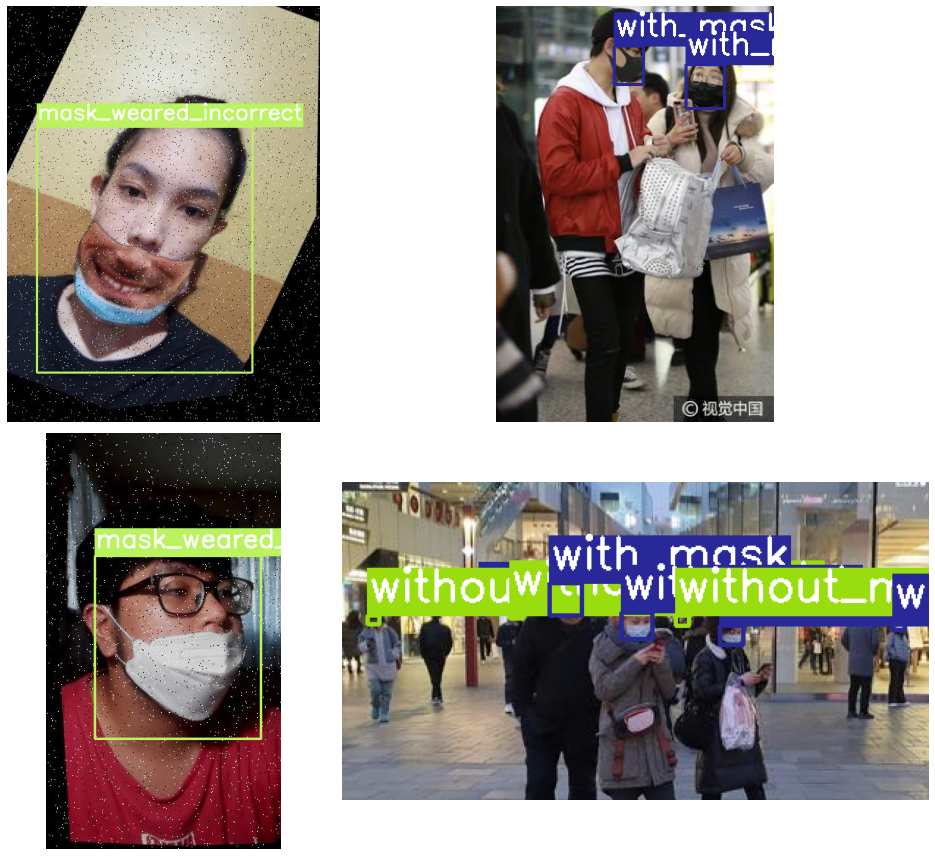

In [ ]:
# Visualize a few training images. Unaugmented photos
plot(
    image_paths='/content/drive/MyDrive/ColabNotebooks/FINAL/train/images/*', 
    label_paths='/content/drive/MyDrive/ColabNotebooks/FINAL/train/labels/*',
    num_samples=4,
)

In [ ]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

In [ ]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train 

In [ ]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/Teeejjj/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 11683, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 11683 (delta 0), reused 0 (delta 0), pack-reused 11680
Receiving objects: 100% (11683/11683), 13.65 MiB | 16.15 MiB/s, done.
Resolving deltas: 100% (7737/7737), done.


In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/FINAL/yolov5
!pwd

/content/drive/MyDrive/ColabNotebooks/FINAL/yolov5
/content/drive/MyDrive/ColabNotebooks/FINAL/yolov5


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data '/content/drive/MyDrive/ColabNotebooks/FINAL/data.yaml' --weights yolov5s.pt \
    --img 416 --epochs {EPOCHS} --batch-size 32 --name {RES_DIR} --optimizer Adam 

Current number of result directories: 1
results_2
train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/ColabNotebooks/FINAL/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=Adam, sync_bn=False, workers=8, project=runs/train, name=results_2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 1 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), 14.28 KiB | 256.00 KiB/s, done.
From https://github.com/ultralytics/yolov5
   c3c8e71..cec1b

In [ ]:
monitor_tensorboard()

<IPython.core.display.Javascript object>

In [ ]:
%reload_ext tensorboard

In [ ]:
#  show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()
        
        
# helpe inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

In [ ]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

confusion_matrix.png				     results.png
events.out.tfevents.1675843036.8c51d70bed61.23332.0  train_batch0.jpg
F1_curve.png					     train_batch1.jpg
hyp.yaml					     train_batch2.jpg
labels_correlogram.jpg				     val_batch0_labels.jpg
labels.jpg					     val_batch0_pred.jpg
opt.yaml					     val_batch1_labels.jpg
P_curve.png					     val_batch1_pred.jpg
PR_curve.png					     val_batch2_labels.jpg
R_curve.png					     val_batch2_pred.jpg
results.csv					     weights
['runs/train/results_2/val_batch0_pred.jpg', 'runs/train/results_2/val_batch1_pred.jpg', 'runs/train/results_2/val_batch2_pred.jpg']


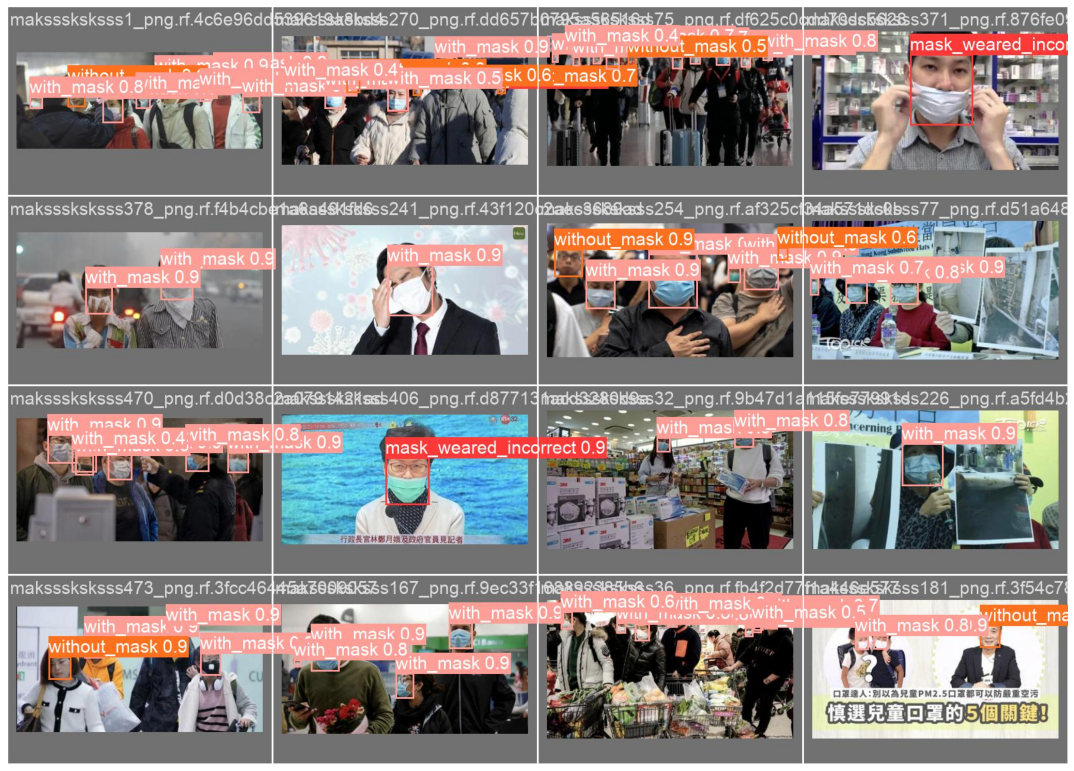

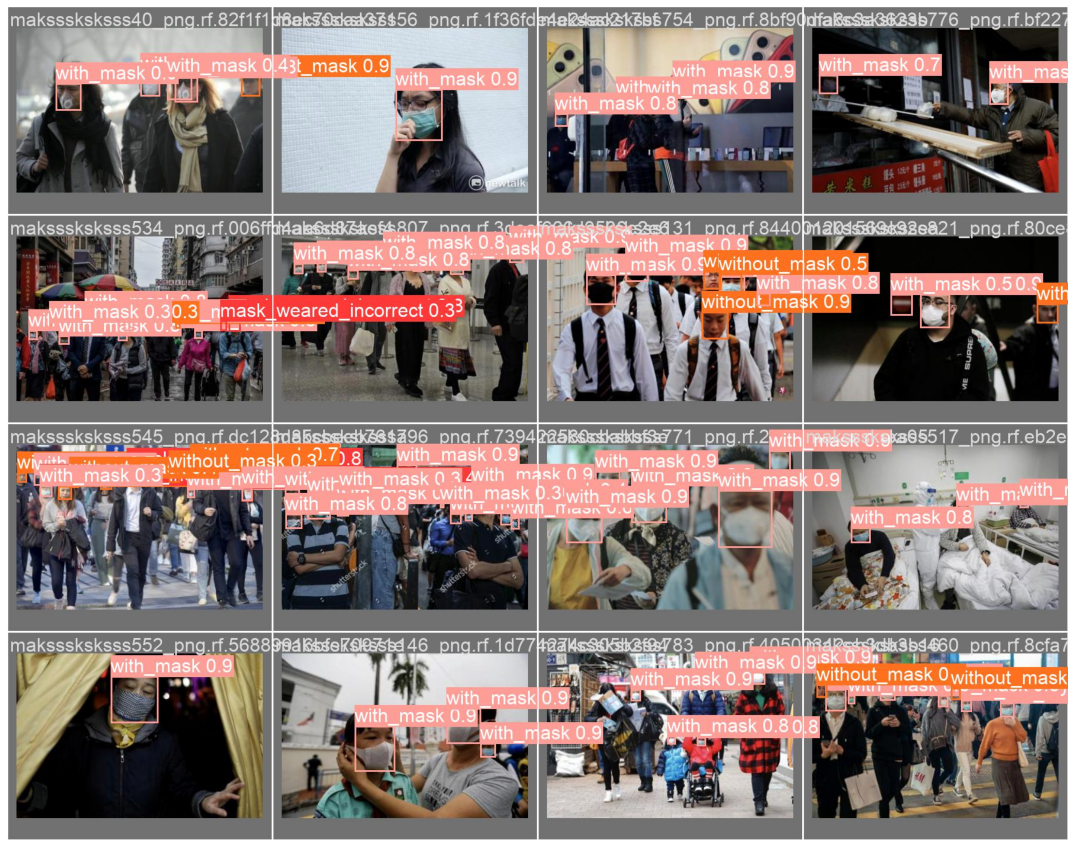

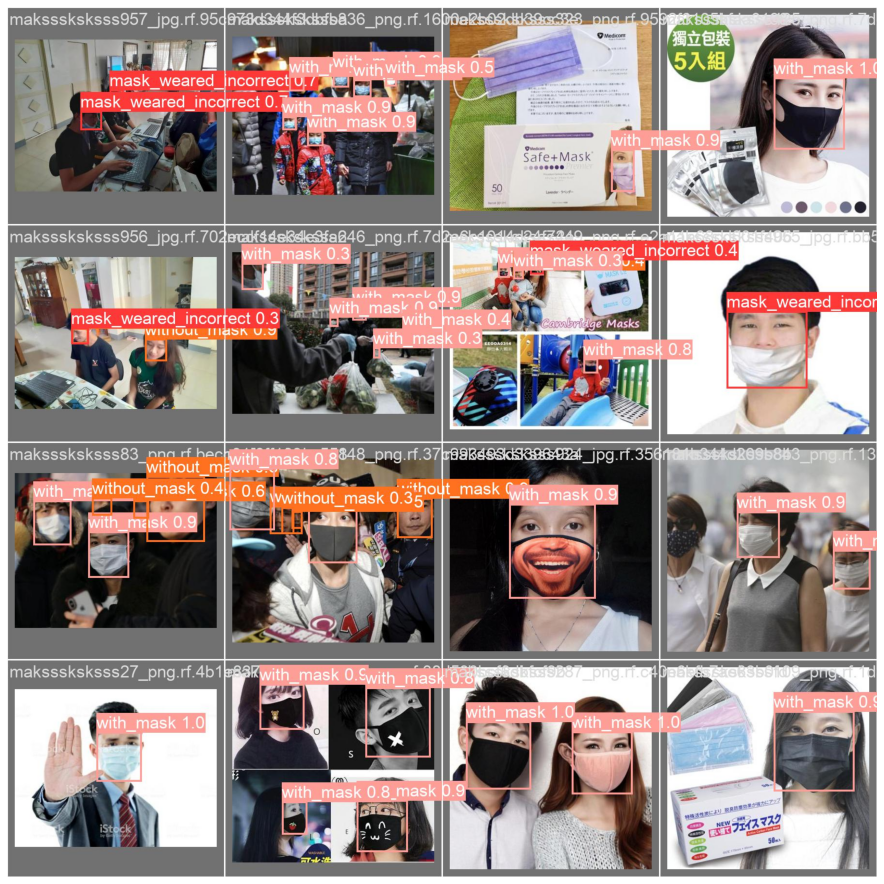

In [ ]:
show_valid_results(RES_DIR)

In [ ]:
!python detect.py --source '/content/drive/MyDrive/ColabNotebooks/FINAL/test/images' --weights runs/train/{RES_DIR}/weights/best.pt --img 416 --save-txt --save-conf

detect: weights=['runs/train/results_2/weights/best.pt'], source=/content/drive/MyDrive/ColabNotebooks/FINAL/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-76-gfb0d84c Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/104 /content/drive/MyDrive/ColabNotebooks/FINAL/test/images/maksssksksss615_png.rf.9c47e189e44e3cf19e5813cb92488cf8.jpg: 416x320 1 without_mask, 13.4ms
image 2/104 /content/drive/MyDrive/ColabNotebooks/FINAL/test/images/maksssksksss670_png.rf.c9ab4ab8911002b8fb67a2e2a5971ea5.jpg: 256x416 5 with_mas

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

path = '/content/drive/MyDrive/ColabNotebooks/FINAL/yolov5/runs/detect/exp'
for file in os.listdir(path):
    if file.endswith(".jpg"):
        image = cv2.imread(os.path.join(path, file))
        height, width = image.shape[:2]
        resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
        
        fig = plt.gcf()
        fig.set_size_inches(18, 10)
        plt.axis("off")
        plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
        plt.show()